In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import math
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score, accuracy_score, precision_score, recall_score, f1_score, auc
from sklearn import preprocessing
import csv

class DMFLDA(nn.Module):
    def __init__(self, lnclen, dilen, lnc_dim1, di_dim1, dim2, dropout_rate):
        super(DMFLDA, self).__init__()

        self.lncLayers = nn.Sequential(
            nn.Linear(dilen, lnc_dim1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(lnc_dim1, dim2),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        self.diLayers = nn.Sequential(
            nn.Linear(lnclen, di_dim1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(di_dim1, dim2),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )


        self.prediction = nn.Sequential(
            nn.Linear(dim2, 1),
            nn.Sigmoid()
        )

    def forward(self, lnc_di, di_lnc):

        lnc_di = self.lncLayers(lnc_di)
        di_lnc = self.diLayers(di_lnc)

        pred = torch.mul(lnc_di, di_lnc)
        pred = self.prediction(pred)

        return pred.squeeze(-1)

In [4]:

def get_data(A, ij, lnclen, dilen):
    lnc_di = []
    di_lnc = []
    for item in ij:
        lnc_di.append(A[item[0]][lnclen: lnclen + dilen])
        di_lnc.append(A[item[1]][:lnclen])
    return np.array(lnc_di), np.array(di_lnc)

class myDataset(Dataset):
    def __init__(self, dataset, fold, lnclen, dilen, mode='train') -> None:
        super().__init__()

        self.mode = mode
        A = np.load('data/' + dataset + '/A_' + str(fold) + '.npy')

        positive_ij = np.load('data/' + dataset + '/positive_ij.npy')
        negative_ij = np.load('data/' + dataset + '/negative_ij.npy')
        positive5foldsidx = np.load('data/' + dataset + '/positive5foldsidx.npy', allow_pickle=True)
        negative5foldsidx = np.load('data/' + dataset + '/negative5foldsidx.npy', allow_pickle=True)

        if mode == 'test':
            positive_test_ij = positive_ij[positive5foldsidx[fold]['test']]
            negative_test_ij = negative_ij[negative5foldsidx[fold]['test']]
            lnc_di, di_lnc = get_data(A, np.concatenate((positive_test_ij, negative_test_ij)), lnclen, dilen)
            self.lnc_di = torch.Tensor(lnc_di)
            self.di_lnc = torch.Tensor(di_lnc)
            self.target = torch.Tensor([1] * len(positive_test_ij) + [0] * len(negative_test_ij))

        elif mode == 'train':
            positive_train_ij = positive_ij[positive5foldsidx[fold]['train']]
            negative_train_ij = negative_ij[negative5foldsidx[fold]['train']]
            lnc_di, di_lnc = get_data(A, np.concatenate((positive_train_ij, negative_train_ij)), lnclen, dilen)
            self.lnc_di = torch.Tensor(lnc_di)
            self.di_lnc = torch.Tensor(di_lnc)
            self.target = torch.Tensor([1] * len(positive_train_ij) + [0] * len(negative_train_ij))

    def __getitem__(self, index):
        if self.mode == 'train':
            return self.lnc_di[index], self.di_lnc[index], self.target[index]
        else:
            return self.lnc_di[index], self.di_lnc[index], self.target[index]

    def __len__(self):
        return len(self.lnc_di)

In [5]:
def prep_dataloader(dataset, fold, mode, lnclen, dilen, batch_size, n_jobs=0):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = myDataset(dataset, fold, lnclen, dilen, mode=mode)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode=='train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

In [6]:

# define draw
def plotCurve(x_vals, y_vals,
                x_label, y_label,
                x2_vals=None, y2_vals=None,
                legend=None,
                figsize=(3.5, 2.5)):
    # set figsize
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')

    if legend:
        plt.legend(legend)

In [7]:
def train(tr_set, model, config, gpu):
    end_loss=[]
    criterion = nn.BCELoss()
    n_epochs = config['n_epochs']
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    loss_record = []
    epoch = 0
    while epoch < n_epochs:
        model.train()
        for lnc_di, di_lnc, y in tr_set:
            optimizer.zero_grad()
            lnc_di, di_lnc, y = lnc_di.to(gpu), di_lnc.to(gpu), y.to(gpu)
            pred = model(lnc_di, di_lnc)
            bce_loss = criterion(pred, y)
            bce_loss.backward()
            optimizer.step()
            loss_record.append(bce_loss.detach().cpu().item())
        epoch += 1

        if bce_loss > 1:
            break
        end_loss.append(bce_loss.detach().cpu().item())
        print(epoch, bce_loss.detach().cpu().item())
        
    print('Finished training after {} epochs'.format(epoch))
    return loss_record,end_loss

In [8]:
def test(tt_set, model, gpu):
    model.eval()
    preds = []
    labels = []
    end_loss= []
    for lnc_di, di_lnc, y in tt_set:
        lnc_di, di_lnc = lnc_di.to(gpu), di_lnc.to(gpu)
        with torch.no_grad():
            pred = model(lnc_di, di_lnc)
            preds.append(pred.detach().cpu())
        labels.append(y.detach().cpu())
    preds = torch.cat(preds, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()

    return labels, preds

In [9]:
# gpu = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
gpu = torch.device("cpu")

config = {
    'n_epochs': 1000,
    'batch_size': 32,
    # 'path': '',
    'dataset': 'dataset1',
    'fold': 4,
    'lnclen': 240,
    'dilen': 412
}

if config['dataset'] == 'dataset1':
    config['lnclen'] = 240
    config['dilen'] = 412
else:
    config['lnclen'] = 665
    config['dilen'] = 316

1 0.36399364471435547
2 0.17646107077598572
3 0.1282840222120285
4 0.17257049679756165
5 0.2102840691804886
6 0.3614952266216278
7 0.1892731487751007
8 0.2629084289073944
9 0.0792684406042099
10 0.39510613679885864
11 0.19513730704784393
12 0.2690865397453308
13 0.2846776843070984
14 0.15509453415870667
15 0.15648414194583893
16 0.30705925822257996
17 0.1855211704969406
18 0.2024502009153366
19 0.15081046521663666
20 0.1777406483888626
21 0.2095082700252533
22 0.15619830787181854
23 0.30850592255592346
24 0.10899792611598969
25 0.19328106939792633
26 0.09125236421823502
27 0.1985948085784912
28 0.11645619571208954
29 0.11152168363332748
30 0.10702645778656006
31 0.1635936051607132
32 0.14667002856731415
33 0.11413440853357315
34 0.13044379651546478
35 0.047444988042116165
36 0.10321809351444244
37 0.11103709042072296
38 0.028836680576205254
39 0.08643884211778641
40 0.08202490955591202
41 0.10107413679361343
42 0.10804571211338043
43 0.060487065464258194
44 0.12140198051929474
45 0.073

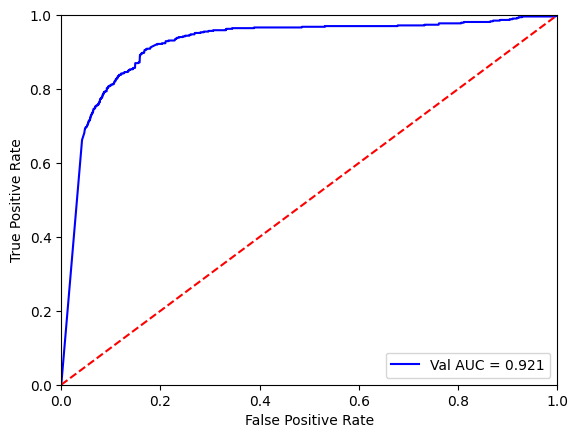

In [10]:
tr_set = prep_dataloader(dataset=config['dataset'], fold=config['fold'], lnclen=config['lnclen'], dilen=config['dilen'], mode='train', batch_size=config['batch_size'])
tt_set = prep_dataloader(dataset=config['dataset'], fold=config['fold'], lnclen=config['lnclen'], dilen=config['dilen'], mode='test', batch_size=config['batch_size'])
model = DMFLDA(config['lnclen'], config['dilen'], 48, 48, 32, 0.05).to(gpu)
model_loss_record,train_end_loss = train(tr_set, model, config, gpu)
# torch.save(model, 'models/DMFLDA/' + ds + '_fold' + str(f) + '.pth')

labels, preds = test(tt_set, model, gpu)
labels = labels.astype(int)
    
fpr, tpr, _ = roc_curve(labels, preds)
AUC = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(labels, preds)
AUPR = auc(recall, precision)
preds = np.array([1 if p > 0.5 else 0 for p in preds])
ACC = accuracy_score(labels, preds)
P = precision_score(labels, preds)
R = recall_score(labels, preds)
F1 = f1_score(labels, preds)
print(AUC, AUPR, ACC, P, R, F1)
print(len(model_loss_record))
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % AUC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig(str(config['fold'])+'_auc_fig')
plt.show()

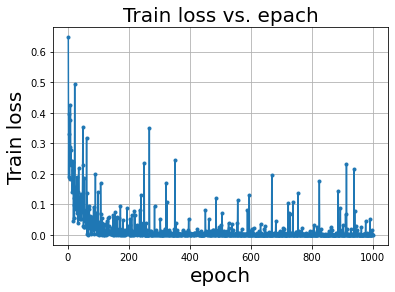

In [51]:
plt.cla()
x1=range(1,config['n_epochs']+1)
plt.title("Train loss vs. epach", fontsize=20)
plt.plot(x1,train_end_loss,'.-')
plt.xlabel('epoch', fontsize=20)
plt.ylabel('Train loss', fontsize=20)
plt.grid()
plt.show()